In [1]:
import numpy as np
#from oneibl.one import ONE
from one.api import ONE
import brainbox.io.one as bbone

from math import *
import sys
import scipy.stats as scist
from os import path

import pandas as pd

from scipy.stats import rankdata



######



one = ONE()
#one.refresh_cache('refresh')

from brainbox.population.decode import get_spike_counts_in_bins

from brainbox.io.one import SpikeSortingLoader, EphysSessionLoader, SessionLoader



from ibllib.atlas import AllenAtlas

ba = AllenAtlas()


from brainbox.task.closed_loop import generate_pseudo_blocks

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ibllib/atlas/__init__.py:205: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


In [12]:
from iblutil.numerical import ismember
from iblutil.numerical import bincount2D
import matplotlib.pyplot as plt

In [3]:
from brainwidemap import bwm_query, bwm_loading

from pathlib import Path
from brainbox.io.one import SessionLoader

from brainwidemap import bwm_units, bwm_query, load_good_units, load_trials_and_mask, filter_sessions, \
    download_aggregate_tables

# Specify a path to download the cluster and trials tables
local_path = Path.home().joinpath('bwm_examples')
local_path.mkdir(exist_ok=True)

In [4]:
def load_passive_rfmap(eid, one=None):
    """
    For a given eid load in the passive receptive field mapping protocol data

    Parameters
    ----------
    eid : [str, UUID, Path, dict]
        Experiment session identifier; may be a UUID, URL, experiment reference string
        details dict or Path
    one : oneibl.one.OneAlyx, optional
        An instance of ONE (may be in 'local' - offline - mode)

    Returns
    -------
    one.alf.io.AlfBunch
        Passive receptive field mapping data
    """
    one = one or ONE()

    # Load in the receptive field mapping data
    rf_map = one.load_object(eid, obj='passiveRFM', collection='alf')
    frames = np.fromfile(one.load_dataset(eid, '_iblrig_RFMapStim.raw.bin',
                                          collection='raw_passive_data'), dtype="uint8")
    y_pix, x_pix = 15, 15
    frames = np.transpose(np.reshape(frames, [y_pix, x_pix, -1], order="F"), [2, 1, 0])
    rf_map['frames'] = frames

    return rf_map

In [5]:
def compute_rf_sta(rf_map, spike_times, spike_clusters,t_bin=0.016666666667, d_bin=0, y_lim=None,x_lim=None, n_time_lag=10):
    """

    Compute receptive field using spike-trigger-average (STA) method
    Parameters
    ----------
    rf_map: output from brainbox.io.one.load_passive_rfmap
    spike_times:
    spike_clusters:

    Returns
    -------
    rf_sta: receptive field of absoluate stimulus (on and off), np.array(number of clusters,x,y,time_lag=0:9(60Hz))
    rf_sta_on: receptive field of On stimulus,   np.array(number of clusters,x,y,time_lag=0:9(60Hz))
    rf_sta_off: receptive field of Off stimulus, np.array(number of clusters,x,y,time_lag=0:9(60Hz))



    """

    rf_map_times = rf_map['times']
    rf_map_frames = rf_map['frames'].astype('float')

    x_bin = rf_map_frames.shape[1]
    y_bin = rf_map_frames.shape[2]

    gray = np.median(rf_map_frames)


    ### binary stimlus table (frame,x,y): white=1, gray=0, dark=-1 #####
    pixel_val = np.round((rf_map_frames-gray)/gray)

    ### binary on-stimlus table (frame,x,y): white=1, gray=0 #####
    pixel_on =np.zeros((len(pixel_val[:,0,0]),len(pixel_val[0,:,0]),len(pixel_val[0,0,:])))
    ### binary off-stimlus table (frame,x,y): dark=1, gray=0 #####
    pixel_off=np.zeros((len(pixel_val[:,0,0]),len(pixel_val[0,:,0]),len(pixel_val[0,0,:])))

    for i_x in range(len(pixel_val[0,:,0])):
        for i_y in range(len(pixel_val[0,0,:])):
            temp_pixel=pixel_val[:,i_x,i_y]
            pixel_on[np.argwhere(temp_pixel>0)[:,0],i_x,i_y]=1
            pixel_off[np.argwhere(temp_pixel<0)[:,0],i_x,i_y]=1


    binned_array, times, depths = bincount2D(spike_times, spike_clusters, t_bin, d_bin, ylim=y_lim, xlim=x_lim)

    #### index for RF mapping begin time #### 
    idx = np.argmin((times - rf_map_times[0]) ** 2)

    n_clusters=len(depths)

    rf_sta=np.zeros((n_clusters,x_bin,y_bin,n_time_lag))
    rf_sta_on=np.zeros((n_clusters,x_bin,y_bin,n_time_lag))
    rf_sta_off=np.zeros((n_clusters,x_bin,y_bin,n_time_lag))

    for i_neuron in range(n_clusters):
        for i_time_lag in range(n_time_lag):

    


            neuron_spike_index=binned_array[i_neuron,:]

            temp_index=np.argwhere(neuron_spike_index>0)[:,0]-idx
            temp_index_2=np.argwhere(temp_index>=0)[:,0]
            temp_index_3=temp_index[temp_index_2]
            temp_index_4=temp_index_3-i_time_lag
            temp_index_5=temp_index_4[np.argwhere(temp_index_4>=0)[:,0]]
            temp_index_6=temp_index_5[np.argwhere(temp_index_5<=len(pixel_val[:,0,0])-1)[:,0]]


            if len(temp_index_6)==0:
                temp_rf_sta=np.zeros((len(pixel_val[0,:,0]),len(pixel_val[0,0,:])))
                temp_rf_sta_on=np.zeros((len(pixel_val[0,:,0]),len(pixel_val[0,0,:])))
                temp_rf_sta_off=np.zeros((len(pixel_val[0,:,0]),len(pixel_val[0,0,:])))
            else:
                temp_rf_sta=np.sum(abs(pixel_val[temp_index_6,:,:]),axis=0)/len(temp_index_6)
                temp_rf_sta_on=np.sum(pixel_on[temp_index_6,:,:],axis=0)/len(temp_index_6)
                temp_rf_sta_off=np.sum(pixel_off[temp_index_6,:,:],axis=0)/len(temp_index_6)

            
            rf_sta[i_neuron,:,:,i_time_lag]=temp_rf_sta
            rf_sta_on[i_neuron,:,:,i_time_lag]=temp_rf_sta_on
            rf_sta_off[i_neuron,:,:,i_time_lag]=temp_rf_sta_off

    

    

    return rf_sta, rf_sta_on, rf_sta_off




In [6]:
def compute_rf_sta_session(pid, eid):
# compute average rf (STA) for each session, returen rf_on/off[number of units, x-position, y-position]   
    

    rf_map=load_passive_rfmap(eid)
   


    #load spikes times
    spikes, clusters = load_good_units(one, pid, compute_metrics=False)
    spike_times=spikes['times']
    spike_clusters=spikes['clusters']

    
    rf_sta, rf_sta_on, rf_sta_off=compute_rf_sta(rf_map, spike_times, spike_clusters,t_bin=0.016666666667, d_bin=0, y_lim=None,x_lim=None, n_time_lag=10)
    
    
    # average of 10 time-lag (1 time-lag=0.016s)
    ave_rf_sta=np.nanmean(rf_sta_on,axis=3)
    ave_rf_sta_on=np.nanmean(rf_sta_on,axis=3)
    ave_rf_sta_off=np.nanmean(rf_sta_off,axis=3)

    
    rf_clusters=np.unique(spike_clusters)
    
    area_label=clusters['atlas_id'][rf_clusters].to_numpy()
    
    beryl_label=ba.regions.remap(area_label, source_map='Allen', target_map='Beryl')
    ############ return cluster id ########################
    QC_cluster_id=clusters['cluster_id'][rf_clusters].to_numpy()    
    
    
            
                  
    return   ave_rf_sta, ave_rf_sta_on, ave_rf_sta_off, rf_sta, rf_sta_on, rf_sta_off, area_label, beryl_label, QC_cluster_id

In [7]:
# example session that contain VISp neurons
pid='799d899d-c398-4e81-abaf-1ef4b02d5475'
eid='e0928e11-2b86-4387-a203-80c77fab5d52'

In [10]:
ave_rf_sta, ave_rf_sta_on, ave_rf_sta_off, rf_sta, rf_sta_on, rf_sta_off, area_label, beryl_label, QC_cluster_id = compute_rf_sta_session(pid, eid)

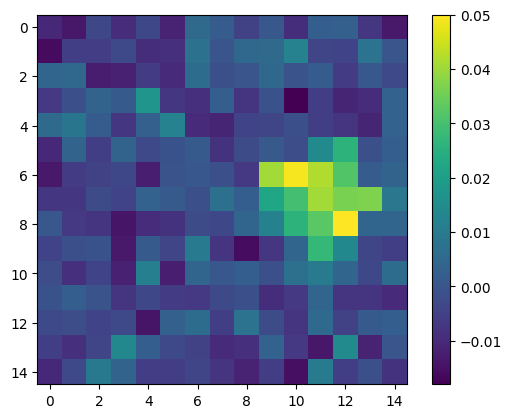

In [16]:
##### example receptive field (On + Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

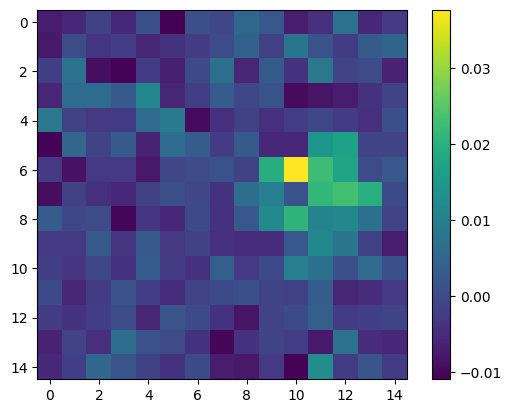

In [17]:
##### example receptive field (On) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta_on[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

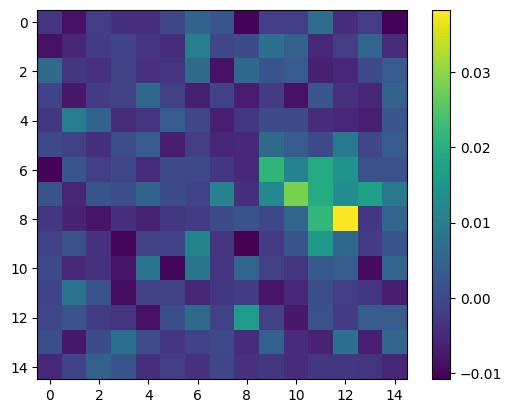

In [15]:
##### example receptive field (Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta_off[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

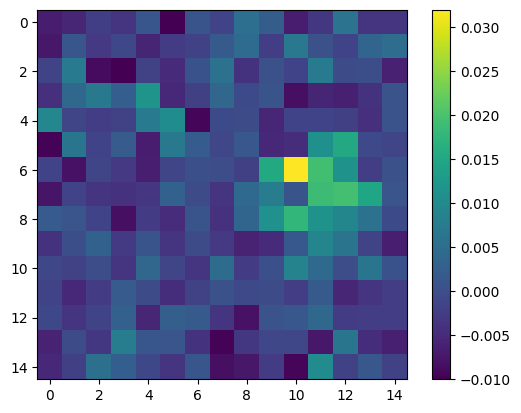

In [46]:
###### time-averaged RF ############

##### example receptive field (On + Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=ave_rf_sta[56,:,:]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()